# Social data analysis - Final Project
## How much money can trees save in New York? 
![](https://raw.githubusercontent.com/ElikaAraghi/Social-Graph/master/project/city.JPG)


## Motivation

Our goal is to visualize the benefits trees bring to New York City. To make it easier to quantify, we've chosen to present them in terms of monetary value. For this purpose, we used 3 different datasets:
1. Foresty Tree Points
2. Eco_benefit
3. New York Geo json dataset

From The *Foresty Tree Points* we found the locations and the conditions of the trees and from *Eco_benefit* we found the money each tree save in four different categories: 
    * Air Pollutants Removed Value In Dollars
    * Co2 Reduced Value In Dollars
    * Energy Conserved Value In Dollars
    * Stormwater Intercepted Value In Dollars
    
Afterwards, we made a map of New York with Geo json data set and add the points with thier location.


## Basic Stats
**Foresty Tree Points** dataset contains 937403 rows and **Eco benefit** contains **770385** rows. The data has been collected since 2015-02-28 and it contains 516 different tree spices
 
First,  we merge these two datasets by the tree ids. 765773 trees wrere mutual in theese two datasets. Then we choose the column below :
1. Condition 
2. Location
3. Air Pollutants Removed Value In Dollars
4. Co2 Reduced Value In Dollars
5. Energy Conserved Value In Dollars
6. Stormwater Intercepted Value In Dollars
Afterwards, we made three new columns and add them to the data frame:
1. Total: Sum of the money that each tree save
2. Lat: Latitude of points
3. Long: longitude of points

In addition, there were trees with **unknown** or **nan** conditions, Since the number of them was small we decided to remove those trees. At the end, to make the visualization more clear we sample from the combined dataset.


In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import csv

# load datasets

tree_points = pd.read_csv("Forestry_Tree_Points.csv")

with open('eco-benefits.json') as json_file:  
    eco = json.load(json_file)
eco = pd.DataFrame.from_dict(eco['data'])

tree_points['CreatedDate'] = pd.to_datetime(tree_points['CreatedDate'])

Here is a sample row from the `Forest_Tree_Points.csv` dataset:

In [2]:
tree_points.head(1)

,OBJECTID,DBH,TPStructure,TPCondition,StumpDiameter,PlantingSpaceGlobalID,Geometry,GlobalID,GenusSpecies,CreatedDate,UpdatedDate,PlantedDate,RiskRating,RiskRatingDate,Location
0,1055852,5.0,Full,Good,0.0,960B0216-AE50-44C0-B79E-369EF6FD0507,POINT (994108.13541689515 148955.26291684806),886F84B2-8720-4F94-984F-2107974C0231,Quercus palustris - pin oak,10/01/2015 01:57:36 PM,NaN,NaN,NaN,NaN,"(40.575518300655716, -73.96451336674765)"


Here is a sample row from the `eco-benefits.csv` dataset:

In [3]:
eco.head(1)

,airPollutantsRemovedInPounds,airPollutantsRemovedValueInDollars,co2ReducedInPounds,co2ReducedValueInDollars,energyConservedInKwH,energyConservedValueInDollars,stormwaterInterceptedInGallons,stormwaterInterceptedValueInDollars,treeId
0,0.76654637,4.01,321.50000000,1.07,484.73993509,61.20,615.52088116,6.09,2134468


We then join the two datasets on the tree ID:

In [9]:
tree_points.rename(columns={"OBJECTID":"treeId"}, inplace=True)

merged_df = pd.merge(eco, tree_points, on=['treeId'])

merged_df.head(1)

,airPollutantsRemovedInPounds,airPollutantsRemovedValueInDollars,co2ReducedInPounds,co2ReducedValueInDollars,energyConservedInKwH,energyConservedValueInDollars,stormwaterInterceptedInGallons,stormwaterInterceptedValueInDollars,treeId,DBH,...,PlantingSpaceGlobalID,Geometry,GlobalID,GenusSpecies,CreatedDate,UpdatedDate,PlantedDate,RiskRating,RiskRatingDate,Location
0,0.76654637,4.01,321.50000000,1.07,484.73993509,61.20,615.52088116,6.09,2134468,9.0,...,A043B200-D0D9-4618-AD90-81B3F729B080,POINT (980405.80895856023 200657.05750018358),81EC7288-90FC-44B4-8087-6767F96528A1,Tilia cordata - littleleaf linden,01/05/2016 02:04:06 PM,NaN,NaN,NaN,NaN,"(40.71743316779006, -74.01386751683981)"


We do not need all the columns in the dataset, so we further reduce it to only contain the columns we need:

In [14]:
#selecting the needed columns from the dataframe
needed_column = merged_df[['TPCondition','Location','airPollutantsRemovedValueInDollars','co2ReducedValueInDollars','energyConservedValueInDollars','stormwaterInterceptedValueInDollars']].copy()

The `Location` columns is a string containing the coordinates of the tree. To make it easier to access these values, we parse each `Location` string and separate the latitude and longitude components into their own separate columns:

In [15]:
#making two columns lat and long which contains latitude and longitude of locations
temp =  (needed_column['Location'].tolist())

temp = [eval(x) for x in temp]

lat = list(zip(*temp))[0]
long = list(zip(*temp))[1]


needed_column['lat'] = lat
needed_column['long'] = long

We then add a column that sums up the dollar values that each tree saves:

In [16]:
#adding a column totals which contains the total money that a tree saves
needed_column['Total']= (needed_column.iloc[:, 2:6].astype(float)).sum(axis=1)

We then remove all rows with `Unknown` or `NaN` tree conditions:

In [16]:
# removing trees with unknown condition and also with value nan
needed_column = needed_column.loc[needed_column['TPCondition'] != 'Unknown']

needed_column = needed_column.loc[needed_column['TPCondition'] != 'nan']

filtered_df = needed_column[needed_column['TPCondition'].notnull()]

Here is the final result of all the data preprocessing:

In [17]:
filtered_df.head(1)

,TPCondition,Location,airPollutantsRemovedValueInDollars,co2ReducedValueInDollars,energyConservedValueInDollars,stormwaterInterceptedValueInDollars,lat,long
0,Good,"(40.71743316779006, -74.01386751683981)",4.01,1.07,61.20,6.09,40.717433,-74.013868


Now we can save and upload the dataset to be accessed by the Observable notebook.

In [20]:
#sample from the data set
sample = filtered_df.sample(50000)

sample.to_csv(r'/home/elika/uni/social_graph/project/sample50000.csv')

In [45]:
#finding the start and end date of the data
times  = list(tree_points['CreatedDate'])

print('start date : ' + str(min(times)))

print('finish date : ' + str(max(times)))

start date : 2015-02-28 05:00:00
finish date : 2019-03-29 16:34:31


# Data Analysis

We've plotted the distribution of the conditions using bar chart and pie chart. Moreover, we found the most common tree spices. Additionally, we show the geographical distributions of trees by ploting heatmaps. Finally, we calculate the total money that trees save.

## Tree Conditions 

In [21]:
conditions = (tree_points.groupby(['TPCondition']).size()).keys()
values_of_conditions = list(tree_points.groupby(['TPCondition']).size())

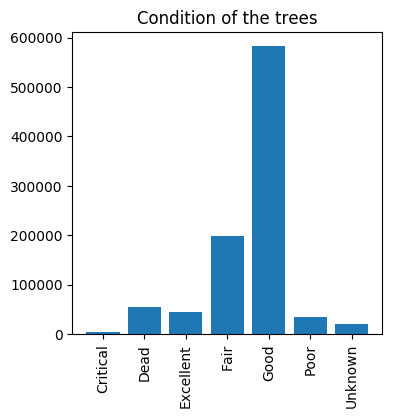

In [58]:

plt.figure(figsize=(4, 4), dpi=100, facecolor='w')
plt.bar(conditions,values_of_conditions)
plt.xticks(rotation=90)
plt.title("Condition of the trees")

plt.show()

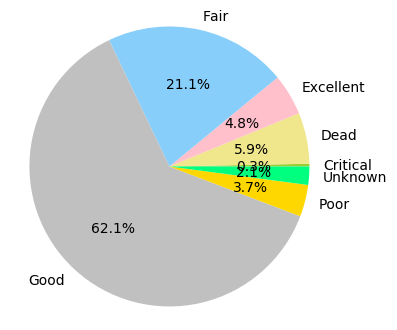

In [59]:
colors = ['yellowgreen', 'khaki','pink' ,'lightskyblue', 'silver','gold', 'springgreen']

plt.figure(figsize=(4, 4), dpi=100, facecolor='w')
plt.pie(values_of_conditions, labels=conditions, colors=colors,autopct='%1.1f%%')

plt.axis('equal')
plt.show()

## Tree Types

In [24]:
tree_types = (tree_points.groupby(['GenusSpecies']).size()).keys()
type_val = list((tree_points.groupby(['GenusSpecies']).size()).keys())

In [39]:
# Most common tree species
spices = (tree_points.groupby(['GenusSpecies']).size()).sort_values(ascending = False)

In [40]:
spices = spices.to_frame()
spices = spices.reset_index()
spices.columns = ['GenusSpecies', 'count']
spices.head(3)

,GenusSpecies,count
0,Platanus x acerifolia - London planetree,110839
1,Gleditsia triacanthos var. inermis - Thornless...,74619
2,Quercus palustris - pin oak,70872


## Tree points and and heatmap using Folium

We've made use of Folium-generated maps as a proof-of-concept of our visualization. We've chosen to visualize the trees on the map, as well as show a density heatmap over New York city.

In [26]:
import folium
from folium import plugins

ny_lat = 40.730610
ny_long = -73.935242

f_map = folium.Map([ny_lat, ny_long], zoom_start=10)

tree_locs = folium.FeatureGroup(name="Tree Locations")

green_trees = ["Excellent", "Good"]
yellow_trees = ["Fair", "Poor", "Critical"]

for coord in filtered_df.sample(n=1000)[['lat', 'long', 'TPCondition']].values:
    color = 'brown' # assume tree is dead
    
    if coord[2] in green_trees:
        color = 'green'
    elif coord[2] in yellow_trees:
        color = 'yellow'
    
    tree_locs.add_child(folium.CircleMarker(
        location=[coord[0], coord[1]],
        radius=1,
        color=color))

f_map.add_child(tree_locs)
f_map

In [28]:
from folium import plugins

f_map = folium.Map([ny_lat, ny_long], zoom_start=10)

f_map.add_child(plugins.HeatMap(filtered_df.sample(n=1000)[['lat', 'long']].values, radius=13))
f_map

## Money

### Dead Trees

In [46]:
dead_trees = merged_df.loc[merged_df['TPCondition'] == 'Dead']

In [47]:
Area = ['airPollutantsRemovedValueInDollars','energyConservedValueInDollars','co2ReducedValueInDollars','stormwaterInterceptedValueInDollars']

In [50]:
for area in Area:
    money = list(dead_trees[area])
    temp = 0
    for i in money:
        try:
            temp = float(i)+temp

        except:
            continue
    print('Total ' + area + '  ' + str(temp))

Total airPollutantsRemovedValueInDollars  291805.9699999622
Total energyConservedValueInDollars  3559840.7100002766
Total co2ReducedValueInDollars  199322.96000001446
Total stormwaterInterceptedValueInDollars  443428.0099999238


### Live Trees

In [52]:
#finding the live trees by removing unknown and Dead trees
live_trees = merged_df.loc[merged_df['TPCondition'] != 'Dead' ]
live_trees = merged_df.loc[merged_df['TPCondition'] != 'Unknown']

In [53]:
for area in Area:
    money = list(live_trees[area])
    temp = 0
    for i in money:
        try:
            temp = float(i)+temp

        except:
            continue
    print('Total ' + area + '  ' + str(temp))

Total airPollutantsRemovedValueInDollars  7086943.709991947
Total energyConservedValueInDollars  89675511.05988549
Total co2ReducedValueInDollars  4430135.069982331
Total stormwaterInterceptedValueInDollars  11454629.74999678


# Genre.
* **Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?**

    **Consistent Visual Platform**
    
    The map is always present on screen. Even when zooming, it is still essentially an interactive map. Furthermore, the accompanying charts beside the map are still visually the same when zooming. They just dynamizally change the information they display based on the trees selected.

    **Zooming**
    
    Users are able to zoom in to see information on a smaller subset of trees.

    **Animated Transitions**
    
    Zooming animations are present when a user chooses to click and center in on a district. The accompanying charts also dynamically change along with it.


* **Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?**

    **Random Access**

    Users are able to randomly filter specific trees they want. They are not linearly directed towards specific trees.

    **Filtering / Selection / Search**

    Users are able to filter the trees they want information from via zooming.

    **Accompanying Article**
    
    The map is accompanied by a histogram showing the distribution of tree conditions, as well as text showing the ecological benefits of the visible trees in dollar values.

# Visualizations

* **Explain the visualizations you've chosen.**

We've chosen to visualize New York's street trees as color-coded points on a map generated with GeoJSON. The color codes are as follows:
* Green : Excellent and good 
* Yellow : Fair and Critical 
* Red : Dead

Accompanying the map is further information on the ecological benefits of the street trees. We are displaying the aggregated benefits of the living trees in dollar values based on how much storm water they intercept, the CO2 they trap, etc. Additionally, we display the dollar values that the dead trees *could have* saved as well.

The map also has the zooming functionality which enables users to zoom in and center on a neighbourhood. The information described before will dynamically update based on the trees still visible after zooming in. When zoomed out, information will be shown for all the visualized trees on the map.


# Discussion

* **What went well?**

    We were lucky to have found a dataset that was both interesting and socially relevant to work with. This made the project fun to work on.
    

* **What is still missing? What could be improved? Why?**

    There was an issue in implementing brushing and click-zooming simultaneously. We wanted to give users as many options as possible to choose the specific trees they need go get information from. At first, we tried to handle brushing with left mouse clicks and zooming with right mouse clicks, but this introduced other bugs in the visualization.
    
    Additionally, we originally wanted to visualize all the trees in the dataset. Due to technical limitations of loading that much data with ObservableHQ, it crashed the site at worst and took a long time to render at best. Because of this, we've chosen to sample a subset of the dataset in order to avoid those issues.

# Contributions
* **You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).**

    * Elika Araghi
    
        * Main editor of explainer notebook
        * Dataset preprocessing on Jupyter notebook
        * Responsible for uploading dataset as Github gist
        * Generate map on Observable notebook via GeoJSON
        
    * Monika Frolcova
    
        * Further processing of data on Observable notebook for visualization
        * Implemented tree selection when zooming or brushing
        * Implemented histogram on Observable notebook to display density of tree conditions
    
    * Mav Cuyugan
    
        * Implemented logic to display trees on map, with different colors and radii based on tree condition
        * Implemented zooming and centering on districts
        * Implemented dollar value text infromation that dynamically changes based on trees selected